# Purpose

### 2021-10-15
In this notebook we upload the subreddit distances calculated in v0.4.0 to BigQuery so that other people can start playing with them and using them.

# Imports & notebook setup

In [1]:
%load_ext google.colab.data_table

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# colab auth for BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
# Attach google drive & import my python utility functions
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

from eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    style_df_numeric,
)

Mounted at /content/gdrive


In [6]:
# install libraries needed to read parquet files from GCS
# !pip install fsspec gcsfs

In [10]:
# !pip list

In [7]:
# Regular Imports
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted

# Load data

Ideally we could just pull the configuration data from github, but for now I'll copy the config from:

`subclu/config/data_embeddings_to_cluster/v0.4.0_2021_10_14-use_multi_lower_case_false_00.yaml`

[Github URL](https://github.snooguts.net/david-bermejo/subreddit_clustering_i18n/blob/djb_v040_expand_and_refactor/subclu/config/data_embeddings_to_cluster/v0.4.0_2021_10_14-use_multi_lower_case_false_00.yaml)

Config text:

```yaml
# embeddings_description: 'Embeddings from USE-multilingual with lower_case=False'
run_uuid: '0591fdae9b7d4da7ae3839767b8aab66'
l_ix_sub: ['subreddit_name', 'subreddit_id']   # 'subreddit_id',  b/c of dask's multi-index, I'm only using name
l_ix_post: ['subreddit_name', 'post_id']

...

df_sub_level_agg_c_post_comments_and_sub_desc: 'df_sub_level_agg_c_post_comments_and_sub_desc'
df_sub_level_agg_c_post_comments_and_sub_desc_similarity: 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity'
df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair: 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair'
df_sub_level_agg_c_post_comments_and_sub_desc_similarity_top_pair: 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_top_pair'

```

In [8]:
bucket = 'i18n-subreddit-clustering'
prefix_similarity_pair_top = (
    "mlflow/mlruns/16/0591fdae9b7d4da7ae3839767b8aab66/"
    "artifacts/df_sub_level_agg_c_post_comments_and_sub_desc_similarity_top_pair"
)

In [9]:
%%time

df_sim_pair_top = pd.read_parquet(
    f"gs://{bucket}/{prefix_similarity_pair_top}"
)
print(df_sim_pair_top.shape)

(3838400, 11)
CPU times: user 2.77 s, sys: 878 ms, total: 3.65 s
Wall time: 9.36 s


In [10]:
df_sim_pair_top.head()

,subreddit_id_a,subreddit_id_b,cosine_distance,subreddit_name_a,subreddit_name_b,German_posts_percent_a,German_posts_percent_b,manual_topic_and_rating_a,manual_topic_and_rating_b,post_median_word_count_a,post_median_word_count_b
0,t5_2qlzfy,t5_3lacy,0.794118,0sanitymemes,shitpostxiv,0.012522,0.018333,internet culture and memes,uncategorized,6.0,7.0
1,t5_2qlzfy,t5_37o2hz,0.775581,0sanitymemes,genshin_memepact,0.012522,0.014167,internet culture and memes,uncategorized,6.0,5.0
2,t5_2qlzfy,t5_ujz0m,0.767907,0sanitymemes,fgomemes,0.012522,0.017182,internet culture and memes,over18_nsfw,6.0,6.0
3,t5_2qlzfy,t5_n5scw,0.755079,0sanitymemes,girlsundshitposts,0.012522,0.053030,internet culture and memes,uncategorized,6.0,5.0
4,t5_2qlzfy,t5_74is2,0.753731,0sanitymemes,okbuddyretard,0.012522,0.033333,internet culture and memes,uncategorized,6.0,4.0


In [19]:
df_sim_pair_top.index

RangeIndex(start=0, stop=3838400, step=1)

# Create overall rank for distances to each subreddit

`Rank for distance for each subreddit`: instead of filtering by cosine distance, we could filter by rank.  We need this because some of the closest subs will be really close and some won't be.

In [39]:
mask_cricket = df_sim_pair_top['subreddit_name_a'].str.contains('cricket')
mask_regg = df_sim_pair_top['subreddit_name_a'].str.contains('regga')
mask_futbol = df_sim_pair_top['subreddit_name_a'].str.contains('futbol')
mask_united = df_sim_pair_top['subreddit_name_a'].str.contains('united')
# mask_cubs = df_sim_pair_top['subreddit_name_a'].str.contains('cubs')
# mask_bears = df_sim_pair_top['subreddit_name_a'].str.contains('bears')

mask_misc = (
    (df_sim_pair_top['subreddit_name_a'].str.contains('gme_'))
    | (df_sim_pair_top['subreddit_name_a'].str.contains('inversi')) 
)

df_test = (
    df_sim_pair_top
    [
        mask_cricket | mask_regg 
        | mask_misc
        # | mask_futbol | mask_united |
        # mask_cubs | mask_bears
    ]
)
df_test.shape

(4200, 12)

In [40]:
value_counts_and_pcts(df_test['subreddit_name_a'])

,subreddit_name_a-count,subreddit_name_a-percent,subreddit_name_a-pct_cumulative_sum
emergingcricket,200,4.8%,4.8%
gme_meltdown,200,4.8%,9.5%
gme_mexico,200,4.8%,14.3%
cricketshitpost,200,4.8%,19.0%
reggaeton,200,4.8%,23.8%
inversionesmexico,200,4.8%,28.6%
cricket,200,4.8%,33.3%
gme_schmelzunter,200,4.8%,38.1%
reggae,200,4.8%,42.9%
cricketwireless,200,4.8%,47.6%


In [41]:
df_test['cosine_distance_rank'] = (
    df_test
    .groupby(['subreddit_name_a'])['cosine_distance'].rank(method='first', ascending=False)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# QA some subreddits

quick spot check to see how the new models are doing

In [42]:
(
    df_test[df_test['cosine_distance_rank'] <= 5]
)

,subreddit_id_a,subreddit_id_b,cosine_distance,subreddit_name_a,subreddit_name_b,German_posts_percent_a,German_posts_percent_b,manual_topic_and_rating_a,manual_topic_and_rating_b,post_median_word_count_a,post_median_word_count_b,cosine_distance_rank
344112,t5_45kmib,t5_3q8lpf,0.837875,gme_capitalists,deepfuckingvalue,0.017751,0.006192,uncategorized,uncategorized,14.0,22.0,1.0
344113,t5_45kmib,t5_43zwn1,0.814532,gme_capitalists,superstonk,0.017751,0.016667,uncategorized,uncategorized,14.0,13.0,2.0
344114,t5_45kmib,t5_43klu5,0.812574,gme_capitalists,gmeamcstonks,0.017751,0.011396,uncategorized,uncategorized,14.0,12.0,3.0
344115,t5_45kmib,t5_48nz4l,0.807114,gme_capitalists,gmejungle,0.017751,0.005833,uncategorized,uncategorized,14.0,11.0,4.0
344116,t5_45kmib,t5_46vgjg,0.805626,gme_capitalists,moass,0.017751,0.000000,uncategorized,uncategorized,14.0,13.5,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3572340,t5_vrs1j,t5_2qhe0,0.806338,emergingcricket,cricket,0.000000,0.001667,sports,uncategorized,11.0,14.0,1.0
3572341,t5_vrs1j,t5_31z5ua,0.755893,emergingcricket,cricketaus,0.000000,0.027397,sports,uncategorized,11.0,12.0,2.0
3572342,t5_vrs1j,t5_37n2x,0.745901,emergingcricket,pakcricket,0.000000,0.000000,sports,uncategorized,11.0,11.5,3.0
3572343,t5_vrs1j,t5_2rnjo,0.740376,emergingcricket,ipl,0.000000,0.012346,sports,sports,11.0,11.0,4.0


# Add data we would need for counterparts

The distances are best used to find counterparts. But to identify counterparts we need to identify:

- Subreddit geo-relevance
- Subreddit language
- Rank for distance for each subreddit

For geo-relevance, we might be better off querying from my custom table to check relevance per country. Otherwise it gets messy when you have multiple countries.

For language: hold off on this because we might need to do more QA and it might be better to use live BQ tables instead of my data snapshot.

`Rank for distance for each subreddit`: instead of filtering by cosine distance, we could filter by rank.  We need this because some of the closest subs will be really close and some won't be.

## Pull v0.3.1

In [ ]:
client = bigquery.Client(project='data-prod-165221')

In [ ]:
%%time
sql_v31 = """
SELECT
    sub.subreddit_name AS subreddit_name
    , sub.combined_topic_and_rating
    , sub.rating
    , sub.topic
    , sub.over_18

    , asr.users_l28
    , asr.posts_l28
    , asr.comments_l28
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_cluster_labels_v031_a` AS sub
LEFT JOIN (
    SELECT * FROM `data-prod-165221.all_reddit.all_reddit_subreddits`
    WHERE DATE(pt) = (CURRENT_DATE() - 2)
) AS asr
    ON sub.subreddit_name = asr.subreddit_name
"""
df_v31 = (
    client.query(sql_v31)
    .to_dataframe()
)
print(df_v31.shape)

(628, 8)
CPU times: user 56.3 ms, sys: 2.46 ms, total: 58.8 ms
Wall time: 3.03 s


## v0.3.2

In [ ]:
%%time
sql_v32 = """
SELECT
  sub.subreddit_name AS subreddit_name
  , sub.combined_topic_and_rating
  , sub.rating
  , nt.rating_short
  , nt.primary_topic
--   , sub.topic
  , sub.over_18

  , asr.users_l28
  , asr.users_l7
  , asr.posts_l28
  , asr.comments_l28

  , geo.* EXCEPT(pt, subreddit_name, over_18)

  , nt.rating_name
  
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_cluster_labels_v032_a` sub
    LEFT JOIN (
        SELECT * FROM `data-prod-165221.all_reddit.all_reddit_subreddits`
        WHERE DATE(pt) = (CURRENT_DATE() - 2)
    ) AS asr
    ON sub.subreddit_name = asr.subreddit_name
    LEFT JOIN (
        SELECT * FROM `reddit-protected-data.cnc_taxonomy_cassandra_sync.shredded_crowdsourced_topic_and_rating`
        WHERE pt = (CURRENT_DATE() - 2)
    ) AS nt
        ON sub.subreddit_id = nt.subreddit_id
    LEFT JOIN(
        SELECT * FROM `data-prod-165221.i18n.all_geo_relevant_subreddits`
        WHERE DATE(pt) = (CURRENT_DATE() - 2)
            AND country IN ('DE')
    ) AS geo
        ON LOWER(geo.subreddit_name) = sub.subreddit_name
;
"""
df_v32 = (
    client.query(sql_v32)
    .to_dataframe()
)
print(df_v32.shape)

(3767, 18)
CPU times: user 174 ms, sys: 9.54 ms, total: 184 ms
Wall time: 4.83 s


## V0.4.0 final

These are from the query AFTER we create the candidates.

For the candidate check, see this other colab notebook:
https://colab.research.google.com/drive/1vvCbYFbrphX5l1kyDhWOUU5frFeb_Wq1


In [ ]:
TODO

In [ ]:
%%time
# need to use `raw` string b/c I have a regex that breaks a regular SQL query
sql_v40 = r"""
SELECT
    sub.subreddit_name AS subreddit_name
    , sub.combined_topic_and_rating
    , sub.over_18
    -- , sub.topic
    , sub.mature_themes_list
    , sub.geo_relevant_countries
    , sub.geo_relevant_country_count
    , sub.geo_relevant_subreddit
    , sub.ambassador_subreddit

    , nt.rating_short
    , nt.rating_name
    , nt.primary_topic

    , asr.users_l28
    , asr.users_l7
    , asr.posts_l28
    , asr.comments_l28

    , geo.* EXCEPT(pt, subreddit_name, over_18)

FROM `reddit-employee-datasets.david_bermejo.subclu_subreddits_top_no_geo_20210924` sub
    LEFT JOIN (
        SELECT * FROM `data-prod-165221.all_reddit.all_reddit_subreddits`
        WHERE DATE(pt) = (CURRENT_DATE() - 2)
    ) AS asr
    ON sub.subreddit_name = asr.subreddit_name
    LEFT JOIN (
        SELECT * FROM `reddit-protected-data.cnc_taxonomy_cassandra_sync.shredded_crowdsourced_topic_and_rating`
        WHERE pt = (CURRENT_DATE() - 2)
    ) AS nt
        ON sub.subreddit_id = nt.subreddit_id

    -- Use as QA to compare v. my geo-relevant query
    LEFT JOIN(
        SELECT * FROM `data-prod-165221.i18n.all_geo_relevant_subreddits`
        WHERE DATE(pt) = '2021-10-10'
            AND country IN ('DE')
    ) AS geo
        ON LOWER(geo.subreddit_name) = sub.subreddit_name
;
"""

df_v40 = (
    client.query(sql_v40)
    .to_dataframe()
)
print(df_v40.shape)

(19262, 22)
CPU times: user 962 ms, sys: 43.5 ms, total: 1 s
Wall time: 12 s


#### Do we have all the ambassador subs?

We should see 170+ as of 2021-09-24. NOTE: some subs are planned but may not be created yet.

In [ ]:
value_counts_and_pcts(df_v40['ambassador_subreddit'])

,ambassador_subreddit-count,ambassador_subreddit-percent,ambassador_subreddit-pct_cumulative_sum
False,"19,091",99.1%,99.1%
True,171,0.9%,100.0%


In [ ]:
value_counts_and_pcts(df_v40['geo_relevant_subreddit'])

,geo_relevant_subreddit-count,geo_relevant_subreddit-percent,geo_relevant_subreddit-pct_cumulative_sum
False,"15,050",78.1%,78.1%
True,"4,212",21.9%,100.0%


In [ ]:
value_counts_and_pcts(df_v40['geo_relevant_countries'], top_n=20)

,geo_relevant_countries-count,geo_relevant_countries-percent,geo_relevant_countries-pct_cumulative_sum
nan,"15,050",78.1%,78.1%
India,970,5.0%,83.2%
Germany,787,4.1%,87.3%
Mexico,400,2.1%,89.3%
United Kingdom,392,2.0%,91.4%
Brazil,381,2.0%,93.3%
Canada,235,1.2%,94.6%
France,213,1.1%,95.7%
Italy,178,0.9%,96.6%
Spain,100,0.5%,97.1%


In [ ]:
# Check DACH
mask_germany = df_v40['geo_relevant_countries'].fillna('').str.contains('Germany')
mask_austria = df_v40['geo_relevant_countries'].fillna('').str.contains('Austria')
mask_switzerland = df_v40['geo_relevant_countries'].fillna('').str.contains('Switzerland')

mask_dach = (mask_germany | mask_austria | mask_switzerland)

value_counts_and_pcts(
    df_v40[mask_dach]['geo_relevant_countries'], 
    top_n=20
).set_caption('DACH-relevant subs')

,geo_relevant_countries-count,geo_relevant_countries-percent,geo_relevant_countries-pct_cumulative_sum
Germany,787,92.0%,92.0%
Switzerland,23,2.7%,94.7%
Austria,20,2.3%,97.1%
"Austria, Germany",13,1.5%,98.6%
"Germany, Switzerland",5,0.6%,99.2%
"France, Germany",3,0.4%,99.5%
"Germany, Italy",1,0.1%,99.6%
"Italy, Switzerland",1,0.1%,99.8%
"Switzerland, United Kingdom",1,0.1%,99.9%
"Germany, United Kingdom",1,0.1%,100.0%


In [ ]:
# Check Germany related subs

value_counts_and_pcts(
    df_v40[mask_germany]['geo_relevant_countries'], 
    top_n=20
).set_caption('Germany-relevant subs')

,geo_relevant_countries-count,geo_relevant_countries-percent,geo_relevant_countries-pct_cumulative_sum
Germany,787,97.2%,97.2%
"Austria, Germany",13,1.6%,98.8%
"Germany, Switzerland",5,0.6%,99.4%
"France, Germany",3,0.4%,99.8%
"Germany, Italy",1,0.1%,99.9%
"Germany, United Kingdom",1,0.1%,100.0%


In [ ]:
mask_india_any = df_v40['geo_relevant_countries'].fillna('').str.contains('India')

value_counts_and_pcts(
    df_v40[mask_india_any]['geo_relevant_countries'], 
    top_n=20
).set_caption('India-relevant subs')

,geo_relevant_countries-count,geo_relevant_countries-percent,geo_relevant_countries-pct_cumulative_sum
India,970,99.4%,99.4%
"India, United Kingdom",3,0.3%,99.7%
"Canada, India",2,0.2%,99.9%
"India, Spain",1,0.1%,100.0%


# Check dif between v0.4.0 candidates & v0.3.1 and v0.3.2


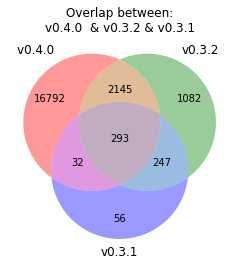

In [ ]:
plt.figure(figsize=(9, 4))
lbls_ = ('v0.4.0 ', 'v0.3.2', 'v0.3.1')
ax = venn3_unweighted(
    [
        set(df_v40['subreddit_name']), 
        set(df_v32['subreddit_name']),
        set(df_v31['subreddit_name']),
    ],
    set_labels=lbls_,
)
plt.title(f"Overlap between:\n{' & '.join(lbls_)}");

## Check subs missing from v0.4.0 candidate


Looks like some of the `1,329` subs missing in the v0.4.0 candidate are NSFW subs, but only a few...


In [ ]:
set_in_v40_but_not_v32 = (
    set(df_v40['subreddit_name']) - set(df_v32['subreddit_name'])
)
set_in_both_v40_and_v32 = (
    set(df_v40['subreddit_name']) & set(df_v32['subreddit_name'])
)
set_in_v32_but_not_v40 = (
    set(df_v32['subreddit_name']) - set(df_v40['subreddit_name'])
)
print(len(set_in_v40_but_not_v32))
print(len(set_in_both_v40_and_v32))
print(len(set_in_v32_but_not_v40))

16824
2438
1329


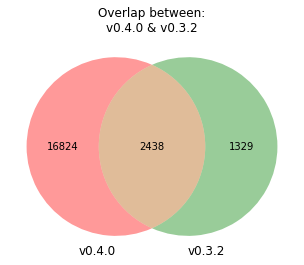

In [ ]:
lbls_ = ('v0.4.0', 'v0.3.2',)
ax = venn2_unweighted(
    [
        set(df_v40['subreddit_name']), 
        set(df_v32['subreddit_name']),
    ],
    set_labels=lbls_,
)
plt.title(f"Overlap between:\n{' & '.join(lbls_)}");

In [ ]:
df_subs_missing_in_v40 = (
    df_v32[df_v32['subreddit_name'].isin(set_in_v32_but_not_v40)]
    .sort_values(by=['posts_l28', 'users_l28', 'comments_l28'], ascending=False)
    .reset_index(drop=True)
)
df_subs_missing_in_v40.shape

(1329, 18)

In [ ]:
df_subs_missing_in_v40.head(10)

,subreddit_name,combined_topic_and_rating,rating,rating_short,primary_topic,over_18,users_l28,users_l7,posts_l28,comments_l28,country,subreddit_id,is_spam,active,is_deleted,verdict,deleted,rating_name
0,relationship_advice,uncategorized,pg13,X,Mature Themes and Adult Content,f,5480662,2035274,55350,757464,None,None,None,None,None,None,None,Sexually Explicit
1,wixbros,over18_nsfw,None,X,Mature Themes and Adult Content,t,319665,122325,30948,54875,DE,t5_3kytod,False,True,False,None,None,Sexually Explicit
2,sex,over18_nsfw,x,X,Mature Themes and Adult Content,f,4838805,1405121,12979,139192,None,None,None,None,None,None,None,Sexually Explicit
3,amihot,over18_nsfw,pg13,X,Mature Themes and Adult Content,f,990526,316841,11644,149563,None,None,None,None,None,None,None,Sexually Explicit
4,tiktokthots,over18_nsfw,nc17,X,Mature Themes and Adult Content,f,1884346,563913,7327,12343,None,None,None,None,None,None,None,Sexually Explicit
5,dating,uncategorized,pg,X,Mature Themes and Adult Content,f,1096352,341482,6920,118569,None,None,None,None,None,None,None,Sexually Explicit
6,goddesses,over18_nsfw,x,X,None,f,1424952,466257,4183,7219,None,None,None,None,None,None,None,Sexually Explicit
7,nsfw_chick_of,uncategorized,None,X,Mature Themes and Adult Content,f,281161,80757,4010,1398,None,None,None,None,None,None,None,Sexually Explicit
8,whatshername,uncategorized,None,X,Mature Themes and Adult Content,f,233076,70998,3638,3889,None,None,None,None,None,None,None,Sexually Explicit
9,beats,uncategorized,r,E,Music,f,6436,1945,3528,478,None,None,None,None,None,None,None,Everyone


In [ ]:
style_df_numeric(df_subs_missing_in_v40[['users_l7', 'posts_l28']].describe().T, float_round=0)

,count,mean,std,min,25%,50%,75%,max
users_l7,"1,329","8,659","74,448",0,415,"1,051","2,080","2,035,274"
posts_l28,"1,329",259,"1,861",0,25,56,122,"55,350"


### How many are Germany-Relevant?

In [ ]:
df_ = (
    df_subs_missing_in_v40
    .query(
        "country == 'DE'"
    )
)
print(df_.shape)
display(df_.head(6))
display(value_counts_and_pcts(df_['rating_short']))

(186, 18)


,subreddit_name,combined_topic_and_rating,rating,rating_short,primary_topic,over_18,users_l28,users_l7,posts_l28,comments_l28,country,subreddit_id,is_spam,active,is_deleted,verdict,deleted,rating_name
1,wixbros,over18_nsfw,None,X,Mature Themes and Adult Content,t,319665,122325,30948,54875,DE,t5_3kytod,False,True,False,None,None,Sexually Explicit
14,deutschetributes,over18_nsfw,None,X,None,t,53422,21475,2981,4137,DE,t5_3nl4m8,False,True,False,None,None,Sexually Explicit
16,sextreffen,over18_nsfw,None,X,Mature Themes and Adult Content,t,25840,8434,2786,2353,DE,t5_2ideas,False,True,False,None,None,Sexually Explicit
19,gaygermany,over18_nsfw,None,X,Mature Themes and Adult Content,t,29702,10179,2639,3384,DE,t5_2ed3nl,False,True,False,None,None,Sexually Explicit
20,germansgonewild,over18_nsfw,x,X,Mature Themes and Adult Content,t,399281,137050,2621,23573,DE,t5_37g5b,False,True,False,None,None,Sexually Explicit
33,sklave,over18_nsfw,None,None,Mature Themes and Adult Content,t,7704,2724,1374,1545,DE,t5_2na5g4,False,True,False,None,None,None


,rating_short-count,rating_short-percent,rating_short-pct_cumulative_sum
nan,87,46.8%,46.8%
X,50,26.9%,73.7%
E,48,25.8%,99.5%
M,1,0.5%,100.0%


In [ ]:
df_ = (
    df_subs_missing_in_v40
    .query(
        "country == 'DE' & rating_short != 'X' & over_18 != 't' & primary_topic != 'Celebrity'"
    )
    .sort_values(by=['users_l7', 'posts_l28'], ascending=False)
)
print(df_.shape)
display(df_)
display(df_['users_l7'].describe())

(20, 18)


,subreddit_name,combined_topic_and_rating,rating,rating_short,primary_topic,over_18,users_l28,users_l7,posts_l28,comments_l28,country,subreddit_id,is_spam,active,is_deleted,verdict,deleted,rating_name
1005,ramona_jst,uncategorized,None,E,None,None,19698,6837,23,178,DE,t5_3arsjy,False,True,False,None,None,Everyone
189,juliabeautxtributs,uncategorized,None,None,Mature Themes and Adult Content,f,13118,3932,234,258,DE,t5_39kg9e,False,True,False,None,None,None
1169,kellymissesvlogof,over18_nsfw,nc17,M,Mature Themes and Adult Content,None,11580,3104,6,1,DE,t5_2sppyj,False,False,False,None,None,Mature
1181,shurjoka,uncategorized,None,E,Internet Culture and Memes,None,2912,1198,5,14,DE,t5_28ihu2,False,False,False,None,None,Everyone
1189,stronggermancelebs,uncategorized,None,None,None,None,3568,929,4,1,DE,t5_3n5vqw,False,False,False,None,None,None
1158,loredanachivu,uncategorized,None,None,None,None,2505,750,7,9,DE,t5_397ri,False,False,False,None,None,None
1160,elisabethmoss,uncategorized,None,E,None,None,1851,601,7,1,DE,t5_2wwu8,False,False,False,None,None,Everyone
1182,giuliagwinn,uncategorized,None,E,Sports,f,1795,518,5,8,DE,t5_2x5kqs,False,False,False,None,None,Everyone
1173,csbundestag,uncategorized,None,E,None,None,2699,460,6,13,DE,t5_3flzd,False,False,False,None,None,Everyone
1220,wasserknaben,uncategorized,None,E,Internet Culture and Memes,None,765,423,2,4,DE,t5_2m5a5m,False,False,False,None,None,Everyone


count      20.000000
mean     1041.700000
std      1694.536611
min        39.000000
25%       199.750000
50%       397.000000
75%       794.750000
max      6837.000000
Name: users_l7, dtype: float64

### How many don't qualify because new: users-l7, post, & comments requirements?

I've increased them so maybe most of these don't meet the new threshold.

#### No comments

We're expecting a minimum of 2 comments

In [ ]:
df_ = (
    df_subs_missing_in_v40
    .query(
        "comments_l28 < 2"
    )
)
print(df_.shape)
df_.head(20)

(119, 18)


,subreddit_name,combined_topic_and_rating,rating,rating_short,primary_topic,over_18,users_l28,users_l7,posts_l28,comments_l28,country,subreddit_id,is_spam,active,is_deleted,verdict,deleted,rating_name
74,24fun,uncategorized,pg13,None,None,f,1569,363,637,1,None,None,None,None,None,None,None,None
149,xcadr,over18_nsfw,x,X,Mature Themes and Adult Content,f,9562,2608,288,0,None,None,None,None,None,None,None,Sexually Explicit
153,bag_o_news,uncategorized,None,None,None,f,947,254,282,0,None,None,None,None,None,None,None,None
249,cellwaters,over18_nsfw,nc17,E,Mature Themes and Adult Content,f,222,67,162,1,None,None,None,None,None,None,None,Everyone
312,tutorials,uncategorized,None,E,Learning and Education,f,638,162,134,1,None,None,None,None,None,None,None,Everyone
358,sittingonclouds,uncategorized,None,E,Music,f,1735,482,112,1,None,None,None,None,None,None,None,Everyone
412,tvcritic,television,pg13,E,Television,f,378,66,95,0,None,None,None,None,None,None,None,Everyone
413,roostertube,uncategorized,pg,E,Podcasts and Streamers,f,277,73,95,1,None,None,None,None,None,None,None,Everyone
493,hacker,uncategorized,r,E,Programming,f,2894,688,79,1,None,None,None,None,None,None,None,Everyone
683,dailyreleases,uncategorized,None,None,None,f,699,202,53,0,None,None,None,None,None,None,None,None


### users-L7 >= Mininum



In [ ]:
df_ = (
    df_subs_missing_in_v40
    .query(
        "users_l7 >= 2100 & rating_short != 'X' & primary_topic != 'Mature Themes and Adult Content'"
    )
    .sort_values(by=['users_l7'], ascending=False)
)
print(df_.shape)
df_.head(10)

(145, 18)


,subreddit_name,combined_topic_and_rating,rating,rating_short,primary_topic,over_18,users_l28,users_l7,posts_l28,comments_l28,country,subreddit_id,is_spam,active,is_deleted,verdict,deleted,rating_name
13,medical,uncategorized,pg13,E,Medical and Mental Health,f,308081,81109,3132,11179,None,None,None,None,None,None,None,Everyone
477,salmahayek,celebrity,r,E,Celebrity,f,87478,26857,80,371,None,None,None,None,None,None,None,Everyone
78,nonakanal,uncategorized,None,E,Celebrity,None,55559,21431,617,1429,DE,t5_2ltn31,False,True,False,None,None,Everyone
313,anna_shumate,uncategorized,None,E,Celebrity,f,54083,18289,133,465,None,None,None,None,None,None,None,Everyone
695,politecats,animals and pets,pg,E,Animals and Pets,f,23900,16708,51,847,None,None,None,None,None,None,None,Everyone
80,annaschmidt,uncategorized,None,E,Celebrity,f,44013,14029,604,1261,DE,t5_2sbqu6,False,True,False,None,None,Everyone
150,lizzywurstonlyfans,uncategorized,None,E,None,f,43466,13411,287,145,None,None,None,None,None,None,None,Everyone
361,tudungmalay,uncategorized,None,E,None,f,32865,12676,111,632,None,None,None,None,None,None,None,Everyone
190,madisonginleyonlyfans,uncategorized,None,E,None,f,29299,11006,233,130,None,None,None,None,None,None,None,Everyone
916,lists,uncategorized,pg,E,None,f,13953,10854,32,125,None,None,None,None,None,None,None,Everyone


In [ ]:
df_v40[df_v40['subreddit_name'].str.contains('goodn')]

,subreddit_name,combined_topic_and_rating,over_18,mature_themes_list,geo_relevant_countries,geo_relevant_country_count,geo_relevant_subreddit,ambassador_subreddit,rating_short,rating_name,primary_topic,users_l28,users_l7,posts_l28,comments_l28,country,subreddit_id,is_spam,active,is_deleted,verdict,deleted
5473,goodnotes,technology,None,,None,NaN,False,False,E,Everyone,Technology,117674,30288,220,1319,None,None,None,None,None,None,None
9174,goodnews,world news,f,,None,NaN,False,False,E,Everyone,World News,7575,2597,106,202,None,None,None,None,None,None,None
15602,gabagoodness,uncategorized,f,"drug_use_education_science_news, drug_use",None,NaN,False,False,E,Everyone,Medical and Mental Health,41966,11413,332,2922,None,None,None,None,None,None,None


In [ ]:
df_subs_missing_in_v40[df_subs_missing_in_v40['subreddit_name'].str.contains('goodn')]

,subreddit_name,combined_topic_and_rating,rating,rating_short,primary_topic,over_18,users_l28,users_l7,posts_l28,comments_l28,country,subreddit_id,is_spam,active,is_deleted,verdict,deleted,rating_name


### Posts >= 100

In [ ]:
df_ = (
    df_subs_missing_in_v40
    .query(
        "posts_l28 >= 80 & rating_short != 'X'"
    )
    .sort_values(by=['users_l7'], ascending=False)
)
print(df_.shape)
df_.head(20)

(369, 18)


,subreddit_name,combined_topic_and_rating,rating,rating_short,primary_topic,over_18,users_l28,users_l7,posts_l28,comments_l28,country,subreddit_id,is_spam,active,is_deleted,verdict,deleted,rating_name
13,medical,uncategorized,pg13,E,Medical and Mental Health,f,308081,81109,3132,11179,None,None,None,None,None,None,None,Everyone
175,elisaalineunconsored,over18_nsfw,None,E,Mature Themes and Adult Content,t,149641,54210,247,147,DE,t5_3fkpat,False,True,False,None,None,Everyone
477,salmahayek,celebrity,r,E,Celebrity,f,87478,26857,80,371,None,None,None,None,None,None,None,Everyone
78,nonakanal,uncategorized,None,E,Celebrity,None,55559,21431,617,1429,DE,t5_2ltn31,False,True,False,None,None,Everyone
239,elisaaline,over18_nsfw,None,None,Mature Themes and Adult Content,t,46806,21118,173,349,DE,t5_39y9gc,False,True,False,None,None,None
313,anna_shumate,uncategorized,None,E,Celebrity,f,54083,18289,133,465,None,None,None,None,None,None,None,Everyone
80,annaschmidt,uncategorized,None,E,Celebrity,f,44013,14029,604,1261,DE,t5_2sbqu6,False,True,False,None,None,Everyone
150,lizzywurstonlyfans,uncategorized,None,E,None,f,43466,13411,287,145,None,None,None,None,None,None,None,Everyone
361,tudungmalay,uncategorized,None,E,None,f,32865,12676,111,632,None,None,None,None,None,None,None,Everyone
237,germantradesnsfw,over18_nsfw,None,E,Mature Themes and Adult Content,t,34159,11097,175,1368,DE,t5_2a8b3h,False,True,False,None,None,Everyone


### How many don't qualify because of new NSFW/Porn ratings?

In [ ]:
display(
    value_counts_and_pcts(
        df_subs_missing_in_v40,
        ['rating_short',]
    )
)
display(
    value_counts_and_pcts(
        df_subs_missing_in_v40,
        ['primary_topic'],
        top_n=10,
    )
)

,count,percent,cumulative_percent
rating_short,,,
E,921,69.3%,69.3%
X,189,14.2%,83.5%
null,180,13.5%,97.1%
M,35,2.6%,99.7%
V,3,0.2%,99.9%
D,1,0.1%,100.0%


,count,percent,cumulative_percent
primary_topic,,,
Mature Themes and Adult Content,222,16.7%,16.7%
null,217,16.3%,33.0%
Celebrity,126,9.5%,42.5%
Internet Culture and Memes,73,5.5%,48.0%
Gaming,70,5.3%,53.3%
Music,55,4.1%,57.4%
Technology,46,3.5%,60.9%
"Business, Economics, and Finance",27,2.0%,62.9%
Place,27,2.0%,64.9%


In [ ]:
# find count of subs that are MISSING for specific reasons
(
    df_subs_missing_in_v40
    .query(
        "~rating_short.isin(['X', 'V', 'D']).values & ~primary_topic.isin(['Mature Themes and Adult Content', 'Celebrity']).values"
    )
    .sort_values(by=['users_l7', 'users_l28'], ascending=False)
)

,subreddit_name,combined_topic_and_rating,rating,rating_short,primary_topic,over_18,users_l28,users_l7,posts_l28,comments_l28,country,subreddit_id,is_spam,active,is_deleted,verdict,deleted,rating_name
13,medical,uncategorized,pg13,E,Medical and Mental Health,f,308081,81109,3132,11179,None,None,None,None,None,None,None,Everyone
695,politecats,animals and pets,pg,E,Animals and Pets,f,23900,16708,51,847,None,None,None,None,None,None,None,Everyone
150,lizzywurstonlyfans,uncategorized,None,E,None,f,43466,13411,287,145,None,None,None,None,None,None,None,Everyone
361,tudungmalay,uncategorized,None,E,None,f,32865,12676,111,632,None,None,None,None,None,None,None,Everyone
190,madisonginleyonlyfans,uncategorized,None,E,None,f,29299,11006,233,130,None,None,None,None,None,None,None,Everyone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,onlyfans_germany,over18_nsfw,None,None,None,t,679,0,2,1,None,None,None,None,None,None,None,None
1320,laurablock,over18_nsfw,None,None,None,t,8,0,0,0,None,None,None,None,None,None,None,None
1326,videoslegaisonline,uncategorized,None,None,None,f,2,0,0,0,None,None,None,None,None,None,None,None
1327,amirawirth,over18_nsfw,None,None,None,t,1,0,0,0,None,None,None,None,None,None,None,None


# [LEGACY] Check diff between v0.3.1 and v0.3.2

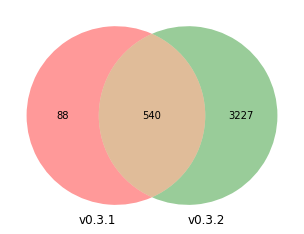

In [ ]:
ax = venn2_unweighted(
    [set(df_v31['subreddit_name']), set(df_v32['subreddit_name'])],
    set_labels=('v0.3.1', 'v0.3.2')
)

# ax.set_title("Overlap between v0.3.1 and v0.3.2")

In [ ]:
set_in_v31_but_not_v32 = (
    set(df_v31['subreddit_name']) - set(df_v32['subreddit_name'])
)
set_in_both_v31_and_v32 = (
    set(df_v31['subreddit_name']) & set(df_v32['subreddit_name'])
)
set_in_v32_but_not_v31 = (
    set(df_v32['subreddit_name']) - set(df_v31['subreddit_name'])
)

### Subs missing from new data

Looks like most of these simply don't have enough posts.

But there are like ~15 subs that have more than 8 posts... not sure if they were dormant when I pulled the data.

In [ ]:
(
    df_v31[df_v31['subreddit_name'].isin(set_in_v31_but_not_v32)]
    .sort_values(by=['posts_l28', 'users_l28', 'comments_l28'], ascending=False)
    .reset_index(drop=True)
)

,subreddit_name,combined_topic_and_rating,rating,topic,over_18,users_l28,posts_l28,comments_l28
0,augenbleiche,reddit institutions,None,None,None,12713,325,678
1,lindnerwichsvorlagen,uncategorized,None,None,None,49637,80,595
2,fremdgehen,over18_nsfw,None,None,t,1351,21,12
3,metallmaimais,uncategorized,None,None,None,1030,18,226
4,studium,uncategorized,None,None,None,549,17,37
...,...,...,...,...,...,...,...,...
83,gamingde,gaming,None,None,f,1,0,0
84,footballmanagerde,gaming,None,None,None,1,0,0
85,pornos_kostenlos,over18_nsfw,None,None,t,1,0,0
86,taynaaa,over18_nsfw,None,None,t,0,0,0


In [ ]:
# these are the subs that have fewer than 4 posts
df_v31[(
    (df_v31['subreddit_name'].isin(set_in_v31_but_not_v32)) &
    (df_v31['posts_l28'] < 4)
)].shape

(59, 8)

# Add new column to check more DE & ambassador subreddits

It's likely there are more than 540 German-relevant subs that we want to tag.

## Load ambassador & DE-relevant subreddits

In [ ]:
%%time
sql_ambassador_subs = """
SELECT 
  LOWER(subreddit_name) AS subreddit_name
  , subreddit_info
  , topic
FROM `reddit-employee-datasets.wacy_su.ambassador_subreddits` 
"""
df_ambassador_subs = (
    client.query(sql_ambassador_subs)
    .to_dataframe()
)
print(df_ambassador_subs.shape)

(171, 3)
CPU times: user 49.1 ms, sys: 4.87 ms, total: 54 ms
Wall time: 2.68 s


In [ ]:
# make sure there's nothing weird with stripping out spaces from subreddit name
assert set(df_ambassador_subs['subreddit_name']) == set(df_ambassador_subs['subreddit_name'].str.strip())

True

In [ ]:
%%time
sql_de_subs = """
SELECT 
  *
FROM `reddit-employee-datasets.wacy_su.geo_relevant_subreddits_2021`
  WHERE geo_country_code = "DE"
"""
df_de_subs = (
    client.query(sql_de_subs)
    .to_dataframe()
)
print(df_de_subs.shape)

(987, 6)
CPU times: user 35.9 ms, sys: 915 µs, total: 36.8 ms
Wall time: 948 ms


## Join with v.3.2 data to check how many are DE/Ambassador subs

In [ ]:
set_subs_de_or_ambassador = (
    set(df_ambassador_subs['subreddit_name']) |
    set(df_de_subs['subreddit_name'])
)
len(set_subs_de_or_ambassador)

1153

In [ ]:
df_v32.head()

,subreddit_name,combined_topic_and_rating,rating,topic,over_18,users_l28,posts_l28,comments_l28
0,artistic_nudity,uncategorized,None,None,f,3539,59,80
1,katjaglieson,uncategorized,None,None,None,1651,7,2
2,workoutgirls,uncategorized,None,None,f,45376,389,1082
3,anime_titties,world news,r,World News,f,171499,577,15603
4,cursedcursedcomments,uncategorized,r,None,f,22760,59,552


In [ ]:
df_v32['geo_relevant_de_or_ambassador'] = np.where(
    df_v32['subreddit_name'].isin(set_subs_de_or_ambassador),
    'DE or Ambassador',
    'Not DE'
) 

In [ ]:
value_counts_and_pcts(df_v32['geo_relevant_de_or_ambassador'])

,geo_relevant_de_or_ambassador-count,geo_relevant_de_or_ambassador-percent,geo_relevant_de_or_ambassador-pct_cumulative_sum
Not DE,"3,180",84.4%,84.4%
DE or Ambassador,587,15.6%,100.0%


### Get the names/info for the 47 subreddits that are German relevant and not in v0.3.1

In [ ]:
set_subs_de_in_v32 = set(df_v32[df_v32['geo_relevant_de_or_ambassador'] == 'DE or Ambassador']['subreddit_name'])

set_subs_de_and_new_in_v32 = (
    set_subs_de_in_v32 -
    set_in_both_v31_and_v32
)
len(set_subs_de_and_new_in_v32)

57

In [ ]:
len(set_subs_de_in_v32)

587

In [ ]:
len(set_in_both_v31_and_v32)

540

Looks like some subs in the previous score where not DE relevant... maybe they were relevant to Austria or Switzerland!

In [ ]:
set_in_both_v31_and_v32.issubset(set_subs_de_in_v32)

False

In [ ]:
set_in_both_v31_and_v32 - set_subs_de_in_v32

{'aeiou',
 'askswitzerland',
 'austria',
 'buenzli',
 'ethz',
 'graz',
 'okoidawappler',
 'switzerland',
 'wien',
 'zurich'}

In [ ]:
len(
    set_subs_de_in_v32 -
    set_in_both_v31_and_v32
)

57

In [ ]:
df_v32[df_v32['subreddit_name'].isin(set_subs_de_and_new_in_v32)].shape

(57, 9)

In [ ]:
(
    df_v32[df_v32['subreddit_name'].isin(set_subs_de_and_new_in_v32)]
    .sort_values(by=['users_l28', 'posts_l28'], ascending=False)
    .reset_index(drop=True)
)

,subreddit_name,combined_topic_and_rating,rating,topic,over_18,users_l28,posts_l28,comments_l28,geo_relevant_de_or_ambassador
0,reved,uncategorized,None,None,f,26273,753,310,DE or Ambassador
1,elisaaline,over18_nsfw,None,None,t,17378,30,43,DE or Ambassador
2,suziegrime,over18_nsfw,None,None,t,13264,1,13,DE or Ambassador
3,kellymissesvlogof,over18_nsfw,nc17,Mature Themes and Adult Content,None,13028,5,0,DE or Ambassador
4,juliabeautxtributs,uncategorized,None,None,f,12308,58,59,DE or Ambassador
5,sophstardustasmrfap,uncategorized,None,None,None,6426,12,52,DE or Ambassador
6,justlucyofficial,uncategorized,None,None,None,6069,9,4,DE or Ambassador
7,kickbasemanager,uncategorized,None,None,f,4098,64,262,DE or Ambassador
8,american_football,uncategorized,None,None,None,3965,122,216,DE or Ambassador
9,reveddit,uncategorized,None,None,None,2666,6,18,DE or Ambassador


In [ ]:
import os
os.getcwd()

'/content'

### Save only the new subs

In [ ]:
(
    df_v32[df_v32['subreddit_name'].isin(set_subs_de_and_new_in_v32)]
    .sort_values(by=['users_l28', 'posts_l28'], ascending=False)
    .reset_index(drop=True)
    .to_csv("/content/gdrive/MyDrive/Colab Notebooks/data/new_DE_subreddits_in_v0.3.2_to_tag.csv")
)

### Create new column for whether subreddit was in v31 and v32

In [ ]:
df_v32.loc[df_v32['subreddit_name'].isin(set_subs_de_or_ambassador)
           , 'subreddit_in_v31_or_v32'] = 'in v0.3.2'

df_v32.loc[df_v32['subreddit_name'].isin(set_in_both_v31_and_v32)
           , 'subreddit_in_v31_or_v32'] = 'in both v0.3.1 & v0.3.2'


In [ ]:
value_counts_and_pcts(
    df_v32[df_v32['subreddit_name'].isin(set_subs_de_or_ambassador)]
    ['subreddit_in_v31_or_v32']
)

,subreddit_in_v31_or_v32-count,subreddit_in_v31_or_v32-percent,subreddit_in_v31_or_v32-pct_cumulative_sum
in both v0.3.1 & v0.3.2,530,90.3%,90.3%
in v0.3.2,57,9.7%,100.0%


## Save all the subs to rate, include user counts & flag for whether sub was included in v31 or v32

In [ ]:
(
    df_v32[df_v32['subreddit_name'].isin(set_subs_de_or_ambassador)]
    .sort_values(by=['users_l28', 'posts_l28'], ascending=False)
    .reset_index(drop=True)
    .to_csv("/content/gdrive/MyDrive/Colab Notebooks/data/All_DE_subreddits_in_v0.3.2_to_tag.csv")
)